In [64]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [65]:
CATEGORIES = {
"Sex": ["M", "F"],
"ChestPainType": ["TA", "ATA", "NAP", "ASY"],
"RestingECG": ["Normal", "ST", "LVH"],
"ExerciseAngina": ["Y", "N"],
"ST_Slope": ["Up", "Flat", "Down"]
}


NUMERIC_COLUMNS = [
"Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"
]

In [66]:
def _build_correlation_matrix(d, rho):
    if d == 1:
        return np.array([[1.0]])
    M = np.full((d, d), rho)
    np.fill_diagonal(M, 1.0)
    return M



In [67]:

def generate_synthetic_data(
    n_samples=1000,
    independence=1.0,
    random_state=42,
    label_balance=0.5,
    max_rho=0.85
):
    np.random.seed(random_state)

    # Generate labels
    n0 = int(n_samples * (1 - label_balance))
    n1 = n_samples - n0
    y = np.array([0]*n0 + [1]*n1)
    np.random.shuffle(y)

    # Class‑specific marginals (to make y informative)
    numeric_marginals = {
        0: {
            "Age": ("uniform", 20, 60),
            "RestingBP": ("uniform", 90, 150),
            "Cholesterol": ("uniform", 120, 300),
            "FastingBS": ("bernoulli", 0.1),
            "MaxHR": ("uniform", 80, 180),
            "Oldpeak": ("uniform", 0, 3)
        },
        1: {
            "Age": ("uniform", 40, 80),
            "RestingBP": ("uniform", 110, 180),
            "Cholesterol": ("uniform", 180, 350),
            "FastingBS": ("bernoulli", 0.3),
            "MaxHR": ("uniform", 60, 150),
            "Oldpeak": ("uniform", 1, 5)
        }
    }

    categorical_marginals = {
        0: {
            "Sex": [0.7, 0.3],
            "ChestPainType": [0.15, 0.35, 0.3, 0.2],
            "RestingECG": [0.6, 0.15, 0.25],
            "ExerciseAngina": [0.15, 0.85],
            "ST_Slope": [0.85, 0.14, 0.01]
        },
        1: {
            "Sex": [0.1, 0.9],
            "ChestPainType": [0.1, 0.1, 0.2, 0.6],
            "RestingECG": [0.6, 0.2, 0.2],
            "ExerciseAngina": [0.6, 0.4],
            "ST_Slope": [0.1, 0.85, 0.05]
        }
    }

    d = len(NUMERIC_COLUMNS) + len(CATEGORIES)
    feature_order = NUMERIC_COLUMNS + list(CATEGORIES.keys())

    # Correlation matrix
    rho = (1 - independence) * max_rho
    corr = _build_correlation_matrix(d, rho)
    L = cholesky(corr, lower=True)

    U = np.zeros((n_samples, d))

    for cls in [0, 1]:
        idx = np.where(y == cls)[0]
        n_cls = len(idx)
        if n_cls == 0:
            continue

        Z = np.random.normal(size=(n_cls, d))
        correlated = Z.dot(L.T)
        U[idx, :] = norm.cdf(correlated)

    # Map marginals
    data = {}
    for i, col in enumerate(feature_order):
        u_col = U[:, i]
        if col in NUMERIC_COLUMNS:
            tmp = []
            for j, cls in enumerate(y):
                spec = numeric_marginals[cls][col]
                if spec[0] == "uniform":
                    a, b = spec[1], spec[2]
                    tmp.append(a + (b - a) * u_col[j])
                elif spec[0] == "bernoulli":
                    p = spec[1]
                    tmp.append(int(u_col[j] < p))
            data[col] = tmp
        else:
            tmp = []
            for j, cls in enumerate(y):
                spec = categorical_marginals[cls][col]
                s = 0
                for index, val in enumerate(spec):
                    s += val
                    if u_col[j] < s:
                        tmp.append(CATEGORIES[col][index])
                        break
            data[col] = tmp

    df = pd.DataFrame(data)
    df["y"] = y
    return df


In [68]:
def save_plots(df, out_dir="./plots/generated"):
    os.makedirs(out_dir, exist_ok=True)

    # Distributions
    for col in df.columns:
        plt.figure(figsize=(6, 4))
        if df[col].dtype == "object":
            sns.countplot(x=df[col])
        else:
            plt.hist(df[col], bins=30)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/{col}_distribution.png")
        plt.close()

    # Global correlation heatmap
    plt.figure(figsize=(10, 8))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap (All Samples)")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/correlation_heatmap_all.png")
    plt.show()
    plt.close()

    # Per‑class correlation heatmaps
    for cls in df["y"].unique():
        plt.figure(figsize=(10, 8))
        corr_cls = df[df["y"] == cls].select_dtypes(include=[np.number]).corr()
        sns.heatmap(corr_cls, annot=True, cmap="coolwarm")
        plt.title(f"Correlation Heatmap (Class {cls})")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/correlation_heatmap_class_{cls}.png")
        plt.close()

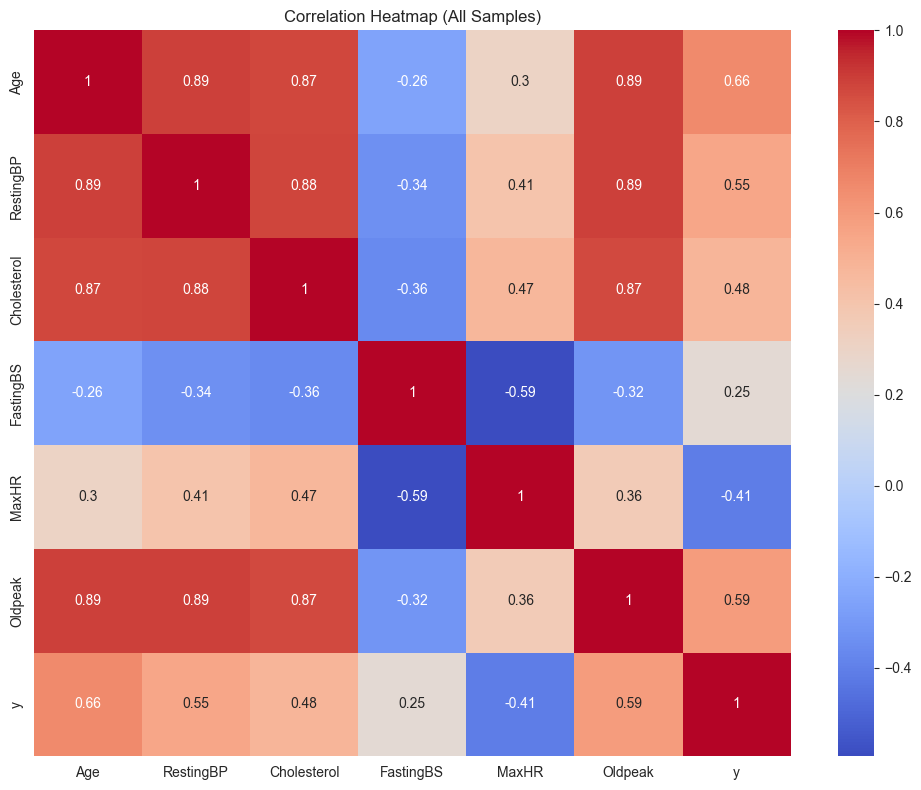

In [69]:
df = generate_synthetic_data(
    n_samples=20000,
    independence=0,
    random_state=42
)
save_plots(df)
df.to_csv('synthetic_heart_data.csv', index=False)

# Understanding the independence parameter

The data generator includes an independence parameter that controls how strongly the features depend on each other. This is important because Naïve Bayes assumes that all features are independent, while Support Vector Machines do not make this assumption.

independence = 1.0 → fully independent features
independence = 0.0 → fully dependent features

## What happens when independence = 1.0

Each feature is generated independently of the others.

Correlations between features are close to zero.

The Naïve Bayes independence assumption holds.

Naïve Bayes is expected to perform well, possibly as well as or better than SVM.

## What happens when independence = 0.0

Features are generated using a shared latent factor, creating strong dependencies.

Many features become correlated or collinear.

The Naïve Bayes assumption is violated.

Naïve Bayes performance is expected to decrease, while SVM is mostly unaffected.

# random_state

The random_state parameter sets the seed for the random number generator.

It ensures that every time you run the code with the same random_state, the generated dataset is exactly the same.

This is useful for reproducibility, so results can be compared or shared.

Changing or removing random_state will generate a different dataset each time.

In [70]:
from sklearn.preprocessing import StandardScaler
def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

    X_processed = pd.get_dummies(X, drop_first=True, dtype=int)

    if not numeric_cols.empty:
        scaler = StandardScaler()
        X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

    return X_processed

     independence  svm_accuracy  gaussian_accuracy
0            0.00        1.0000             0.8825
1            0.01        1.0000             0.8875
2            0.02        1.0000             0.8875
3            0.03        1.0000             0.8875
4            0.04        1.0000             0.8875
..            ...           ...                ...
96           0.96        0.9875             0.9475
97           0.97        0.9875             0.9475
98           0.98        0.9850             0.9525
99           0.99        0.9850             0.9525
100          1.00        0.9875             0.9475

[101 rows x 3 columns]


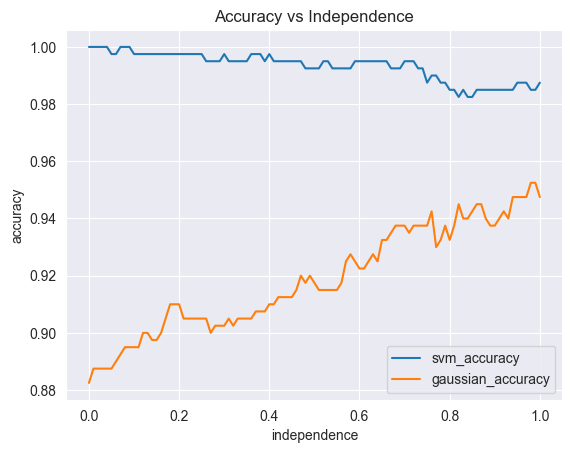

In [71]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

samples = 2000
independence_steps = np.round(np.arange(0, 1.01, 0.01), 2)



accuraccy = pd.DataFrame(columns=["independence", "svm_accuracy", "gaussian_accuracy"])

for independence_step in independence_steps:
    data = generate_synthetic_data(
        n_samples=samples,
        independence=independence_step,
        random_state=42
    )

    X = scale_features(data.loc[:, data.columns != 'y'])
    Y = data['y']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    svm_model = SVC(kernel='rbf', random_state=42)
    gaussian_model = GaussianNB()
    # Fit the model
    svm_model.fit(X_train, y_train)
    gaussian_model.fit(X_train, y_train)

    # Predict with model
    y_pred_svm = svm_model.predict(X_test)
    y_pred_gaussian = gaussian_model.predict(X_test)

    # Gain accuracy score
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    gaussian_accuracy = accuracy_score(y_test, y_pred_gaussian)
    accuraccy.loc[len(accuraccy)] = [independence_step, svm_accuracy, gaussian_accuracy]

print(accuraccy)
plt.figure()
plt.plot(accuraccy["independence"], accuraccy["svm_accuracy"], label="svm_accuracy")
plt.plot(accuraccy["independence"], accuraccy["gaussian_accuracy"], label="gaussian_accuracy")
plt.xlabel("independence")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs Independence")
plt.show()
